In [1]:
# This notebook...

In [2]:
!pwd

/Users/sr_old/Desktop/attention_seq2seq


In [3]:
import sys
print(sys.executable)
print(sys.version)

/Users/sr_old/Desktop/attention_seq2seq/p3.10_attention_seq2seq/bin/python
3.10.13 (main, Aug 24 2023, 22:36:46) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [4]:
colab = False

if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")

## Imports

In [5]:
import math
import re

In [6]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader #, TensorDataset
from torch.utils.data.dataset import random_split
import datetime

In [7]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [8]:
from torch.distributions.categorical import Categorical

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline    
from matplotlib.pyplot import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 5,5

In [10]:
import itertools
import random

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import pickle

In [13]:
from dataprep_functions import LanguageDataset

In [14]:
from model_functions import *

## Device and seed

In [15]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'

device

'mps'

In [16]:
seed = 42

In [17]:
torch.manual_seed(seed)
#rng = np.random.default_rng(seed)
random.seed(seed)

## Variables

In [18]:
if colab:
  path = "/content/gdrive/MyDrive/attention_seq2seq/datasets"
  results_path = "results"

else:
    # Name of the folder where data is accessed and saved
    path = "datasets"
    # Name of the folder for training results
    results_path = "results"

In [19]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

## Loading the data we need

In [20]:
# Unpickling
with open(path + "/input_lang.txt", "rb") as y:
    input_lang = pickle.load(y)
with open(path + "/output_lang.txt", "rb") as y:
    output_lang = pickle.load(y)

In [21]:
# This is a small dataset, useful for debugging.
trial_dataset1 = torch.load(path + '/trial1.pt', weights_only=False)
trial_dataset2 = torch.load(path + '/trial2.pt', weights_only=False)

In [22]:
trial_dataset1[1:5]

((tensor([[ 10,   7, 154, 357],
          [117,   4,  50,  88],
          [  3,   2, 646,   9],
          [ 62,   0, 450,   2],
          [  6,   0,   6,   0],
          [  2,   0,   2,   0]]),
  [6, 3, 6, 4]),
 (tensor([[113,  24,  92, 162],
          [611,  60, 178, 430],
          [194,   6, 701,  42],
          [ 76,   2, 410, 191],
          [  4,   0,   4,   8],
          [  2,   0,   2,   2]]),
  [6, 4, 6, 6]))

In [23]:
train_dataset = torch.load(path + '/train.pt', weights_only=False)
val_dataset = torch.load(path + '/val.pt', weights_only=False)

In [24]:
len(train_dataset)

5159

## Checking the model works

In [25]:
m = Luong_full(vocab = input_lang.n_words, h_size = 2, dropout = 0, n_layers = 2, 
                    att_method = 'dot', vocab_out = output_lang.n_words, device = device)
m.to(device)

Luong_full(
  (encoder): EncoderRNN(
    (embedding): Embedding(655, 2)
    (gru): GRU(2, 1, num_layers=2, bidirectional=True)
  )
  (decoder): LuongDecoder(
    (embedding): Embedding(705, 2)
    (gru): GRU(2, 2, num_layers=2)
    (joinerFF): Linear(in_features=4, out_features=2, bias=True)
    (projFF): Linear(in_features=2, out_features=705, bias=True)
    (dropout_layer): Dropout(p=0, inplace=False)
    (alignment_vector): Attn()
  )
)

## Now train

In [28]:
# Parameter definitions:
#
#       lrate - learning rate
#
#       ratio - we set the decoder learning rate to lrate*ratio
#
#       bsize*acc_steps - this multiple gives the true batch size; acc_steps is the number of gradient accumulation steps done at training
#
#       bsize_eval - the batch size used when evaluating the model at the end of an epoch (train and val losses)
#
#       patience - regulates early stopping
#
#       h_size - this regulates the dimensionality of the neural nets used
#
#       dropout - we haev inserted dropout in multiple places
#
#       n_layers - the number of layers in the encoder and decoder GRUs
#
#       att_method - one of ['dot', 'general', 'concat']
#
#       c - a string to be added in the saved files' filename
#

18:48:49  Starting epoch 0
18:49:34  Calculating figures
18:49:51  Ending epoch 0    train_loss: 3.32   val_loss: 3.34
18:49:51  Starting epoch 1
18:50:36  Calculating figures
18:50:55  Ending epoch 1    train_loss: 2.92   val_loss: 2.98
18:50:55  Starting epoch 2
18:51:42  Calculating figures
18:52:02  Ending epoch 2    train_loss: 2.69   val_loss: 2.76
18:52:02  Starting epoch 3
18:52:48  Calculating figures
18:53:09  Ending epoch 3    train_loss: 2.5   val_loss: 2.63
18:53:09  Starting epoch 4
18:53:56  Calculating figures
18:54:19  Ending epoch 4    train_loss: 2.38   val_loss: 2.53
18:54:19  Starting epoch 5
18:55:07  Calculating figures
18:55:31  Ending epoch 5    train_loss: 2.32   val_loss: 2.5
18:55:31  Starting epoch 6
18:56:20  Calculating figures
18:56:44  Ending epoch 6    train_loss: 2.22   val_loss: 2.42
18:56:44  Starting epoch 7
18:57:34  Calculating figures
18:58:00  Ending epoch 7    train_loss: 2.14   val_loss: 2.37

best training_loss = 2.1409, best validation_loss

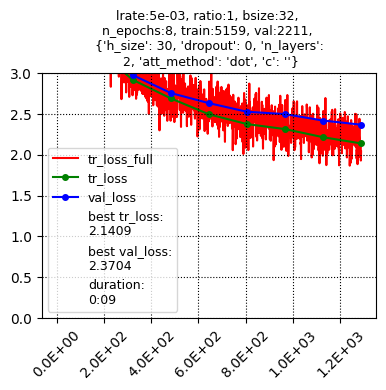

   192|         0|            0|            0|  0.00%|    bias: optional bias of shape :math:`(\text{out\_channels})`. Default: None
   193|         0|            0|            0|  0.00%|    stride: the stride of the convolving kernel. Can be a single number or a
   194|         0|            0|            0|  0.00%|      tuple ``(sW,)``. Default: 1
   195|         0|            0|            0|  0.00%|    padding: ``dilation * (kernel_size - 1) - padding`` zero-padding will be added to both
   196|         0|            0|            0|  0.00%|      sides of each dimension in the input. Can be a single number or a tuple
   197|         0|            0|            0|  0.00%|      ``(padW,)``. Default: 0
   198|         0|            0|            0|  0.00%|    output_padding: additional size added to one side of each dimension in the
   199|         0|            0|            0|  0.00%|      output shape. Can be a single number or a tuple ``(out_padW)``. Default: 0
   200|         0| 

   560|         0|            0|            0|  0.00%|        ]
   561|         0|            0|            0|  0.00%|
   562|         0|            0|            0|  0.00%|    if _random_samples is None:
   563|         0|            0|            0|  0.00%|        _random_samples = torch.rand(input.size(0), input.size(1), 3, dtype=input.dtype, device=input.device)
   564|         0|            0|            0|  0.00%|    return torch._C._nn.fractional_max_pool3d(input, kernel_size, output_size, _random_samples)
   565|         0|            0|            0|  0.00%|
   566|         0|            0|            0|  0.00%|
   567|         0|            0|            0|  0.00%|def _fractional_max_pool3d(
   568|         0|            0|            0|  0.00%|    input: Tensor, kernel_size: BroadcastingList3[int],
   569|         0|            0|            0|  0.00%|    output_size: Optional[BroadcastingList3[int]] = None,
   570|         0|            0|            0|  0.00%|    output_ra

   932|         0|            0|            0|  0.00%|def lp_pool2d(
   933|         0|            0|            0|  0.00%|    input: Tensor, norm_type: float,
   934|         0|            0|            0|  0.00%|    kernel_size: int,
   935|         0|            0|            0|  0.00%|    stride: Optional[BroadcastingList2[int]] = None,
   936|         0|            0|            0|  0.00%|    ceil_mode: bool = False
   937|         0|            0|            0|  0.00%|) -> Tensor:
   938|         0|            0|            0|  0.00%|    r"""Applies a 2D power-average pooling over an input signal composed of
   939|         0|            0|            0|  0.00%|    several input planes. If the sum of all inputs to the power of `p` is
   940|         0|            0|            0|  0.00%|    zero, the gradient is set to zero as well.
   941|         0|            0|            0|  0.00%|
   942|         0|            0|            0|  0.00%|    See :class:`~torch.nn.LPPool2d` for 

  1273|         0|            0|            0|  0.00%|# We define this function as _threshold because it takes an argument
  1274|         0|            0|            0|  0.00%|# named threshold, which clobbers the recursive reference to the
  1275|         0|            0|            0|  0.00%|# function needed for __torch_function__ support
  1276|         0|            0|            0|  0.00%|threshold = _threshold
  1277|         0|            0|            0|  0.00%|
  1278|         0|            0|            0|  0.00%|threshold_ = _add_docstr(
  1279|         0|            0|            0|  0.00%|    _VF.threshold_,
  1280|         0|            0|            0|  0.00%|    r"""
  1281|         0|            0|            0|  0.00%|threshold_(input, threshold, value) -> Tensor
  1282|         0|            0|            0|  0.00%|
  1283|         0|            0|            0|  0.00%|In-place version of :func:`~threshold`.
  1284|         0|            0|            0|  0.00%|"""

  1640|         0|            0|            0|  0.00%|        return handle_torch_function(softmin, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)
  1641|         0|            0|            0|  0.00%|    if dim is None:
  1642|         0|            0|            0|  0.00%|        dim = _get_softmax_dim("softmin", input.dim(), _stacklevel)
  1643|         0|            0|            0|  0.00%|    if dtype is None:
  1644|         0|            0|            0|  0.00%|        ret = (-input).softmax(dim)
  1645|         0|            0|            0|  0.00%|    else:
  1646|         0|            0|            0|  0.00%|        ret = (-input).softmax(dim, dtype=dtype)
  1647|         0|            0|            0|  0.00%|    return ret
  1648|         0|            0|            0|  0.00%|
  1649|         0|            0|            0|  0.00%|
  1650|         8|  3.19481e-05|  3.99351e-06|  0.01%|def softmax(input: Tensor, dim: Optional[int] = None, _stacklevel: int = 3

  2110|         0|            0|            0|  0.00%|            of shape `(B)`, :attr:`input` will be viewed as having ``B`` bags.
  2111|         0|            0|            0|  0.00%|            Empty bags (i.e., having 0-length) will have returned vectors filled by zeros.
  2112|         0|            0|            0|  0.00%|
  2113|         0|            0|            0|  0.00%|        - :attr:`weight` (Tensor): the learnable weights of the module of shape `(num_embeddings, embedding_dim)`
  2114|         0|            0|            0|  0.00%|
  2115|         0|            0|            0|  0.00%|        - :attr:`per_sample_weights` (Tensor, optional). Has the same shape as :attr:`input`.
  2116|         0|            0|            0|  0.00%|
  2117|         0|            0|            0|  0.00%|        - :attr:`output`: aggregated embedding values of shape `(B, embedding_dim)`
  2118|         0|            0|            0|  0.00%|
  2119|         0|            0|            0|  

  2509|         0|            0|            0|  0.00%|    Example::
  2510|         0|            0|            0|  0.00%|
  2511|         0|            0|            0|  0.00%|        >>> # input is of size N x C = 3 x 5
  2512|         0|            0|            0|  0.00%|        >>> input = torch.randn(3, 5, requires_grad=True)
  2513|         0|            0|            0|  0.00%|        >>> # each element in target has to have 0 <= value < C
  2514|         0|            0|            0|  0.00%|        >>> target = torch.tensor([1, 0, 4])
  2515|         0|            0|            0|  0.00%|        >>> output = F.nll_loss(F.log_softmax(input), target)
  2516|         0|            0|            0|  0.00%|        >>> output.backward()
  2517|         0|            0|            0|  0.00%|    """
  2518|         0|            0|            0|  0.00%|    if has_torch_function_variadic(input, target, weight):
  2519|         0|            0|            0|  0.00%|        return handl

  2794|         0|            0|            0|  0.00%|            some losses, there multiple elements per sample. If the field :attr:`size_average`
  2795|         0|            0|            0|  0.00%|            is set to ``False``, the losses are instead summed for each minibatch. Ignored
  2796|         0|            0|            0|  0.00%|            when reduce is ``False``. Default: ``True``
  2797|         0|            0|            0|  0.00%|        ignore_index (int, optional): Specifies a target value that is ignored
  2798|         0|            0|            0|  0.00%|            and does not contribute to the input gradient. When :attr:`size_average` is
  2799|         0|            0|            0|  0.00%|            ``True``, the loss is averaged over non-ignored targets. Note that
  2800|         0|            0|            0|  0.00%|            :attr:`ignore_index` is only applicable when the target contains class indices.
  2801|         0|            0|          

  3073|         0|            0|            0|  0.00%|            "This will likely lead to incorrect results due to broadcasting. "
  3074|         0|            0|            0|  0.00%|            "Please ensure they have the same size.".format(target.size(), input.size()),
  3075|         0|            0|            0|  0.00%|            stacklevel=2,
  3076|         0|            0|            0|  0.00%|        )
  3077|         0|            0|            0|  0.00%|    if size_average is not None or reduce is not None:
  3078|         0|            0|            0|  0.00%|        reduction = _Reduction.legacy_get_string(size_average, reduce)
  3079|         0|            0|            0|  0.00%|
  3080|         0|            0|            0|  0.00%|    expanded_input, expanded_target = torch.broadcast_tensors(input, target)
  3081|         0|            0|            0|  0.00%|    return torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
  3082| 

  3339|         0|            0|            0|  0.00%|    if size_average is not None or reduce is not None:
  3340|         0|            0|            0|  0.00%|        reduction_enum = _Reduction.legacy_get_enum(size_average, reduce)
  3341|         0|            0|            0|  0.00%|    else:
  3342|         0|            0|            0|  0.00%|        reduction_enum = _Reduction.get_enum(reduction)
  3343|         0|            0|            0|  0.00%|    if p != 1 and p != 2:
  3344|         0|            0|            0|  0.00%|        raise ValueError("only p == 1 and p == 2 supported")
  3345|         0|            0|            0|  0.00%|    if weight is not None:
  3346|         0|            0|            0|  0.00%|        if weight.dim() != 1:
  3347|         0|            0|            0|  0.00%|            raise ValueError("weight must be one-dimensional")
  3348|         0|            0|            0|  0.00%|
  3349|         0|            0|            0|  0.00%|   

  3615|         0|            0|            0|  0.00%|            input,
  3616|         0|            0|            0|  0.00%|            size=size,
  3617|         0|            0|            0|  0.00%|            scale_factor=scale_factor,
  3618|         0|            0|            0|  0.00%|            mode=mode,
  3619|         0|            0|            0|  0.00%|            align_corners=align_corners,
  3620|         0|            0|            0|  0.00%|            recompute_scale_factor=recompute_scale_factor,
  3621|         0|            0|            0|  0.00%|        )
  3622|         0|            0|            0|  0.00%|
  3623|         0|            0|            0|  0.00%|    if mode in ("nearest", "area"):
  3624|         0|            0|            0|  0.00%|        if align_corners is not None:
  3625|         0|            0|            0|  0.00%|            raise ValueError(
  3626|         0|            0|            0|  0.00%|                "align_corners op

  3900|         0|            0|            0|  0.00%|
  3901|         0|            0|            0|  0.00%|        * ``padding_mode="zeros"``: use ``0`` for out-of-bound grid locations,
  3902|         0|            0|            0|  0.00%|        * ``padding_mode="border"``: use border values for out-of-bound grid locations,
  3903|         0|            0|            0|  0.00%|        * ``padding_mode="reflection"``: use values at locations reflected by
  3904|         0|            0|            0|  0.00%|          the border for out-of-bound grid locations. For location far away
  3905|         0|            0|            0|  0.00%|          from the border, it will keep being reflected until becoming in bound,
  3906|         0|            0|            0|  0.00%|          e.g., (normalized) pixel location ``x = -3.5`` reflects by border ``-1``
  3907|         0|            0|            0|  0.00%|          and becomes ``x' = 1.5``, then reflects by border ``1`` and becomes
  39

  4260|         0|            0|            0|  0.00%|to a common shape. ``dim`` refers to the dimension in this common shape. Dimension ``dim`` of the output is
  4261|         0|            0|            0|  0.00%|squeezed (see :func:`torch.squeeze`), resulting in the
  4262|         0|            0|            0|  0.00%|output tensor having 1 fewer dimension.
  4263|         0|            0|            0|  0.00%|
  4264|         0|            0|            0|  0.00%|.. math ::
  4265|         0|            0|            0|  0.00%|    \text{similarity} = \dfrac{x_1 \cdot x_2}{\max(\Vert x_1 \Vert _2 \cdot \Vert x_2 \Vert _2, \epsilon)}
  4266|         0|            0|            0|  0.00%|
  4267|         0|            0|            0|  0.00%|Supports :ref:`type promotion <type-promotion-doc>`.
  4268|         0|            0|            0|  0.00%|
  4269|         0|            0|            0|  0.00%|Args:
  4270|         0|            0|            0|  0.00%|    x1 (Tensor): First 

  4680|         0|            0|            0|  0.00%|    if len(padding) > 4:
  4681|         0|            0|            0|  0.00%|        if padding[-6] > 0:
  4682|         0|            0|            0|  0.00%|            i0 = out_shape[4] - padding[-6] - max(padding[-5], 0)
  4683|         0|            0|            0|  0.00%|            i1 = out_shape[4] - max(padding[-5], 0)
  4684|         0|            0|            0|  0.00%|            o0 = 0
  4685|         0|            0|            0|  0.00%|            o1 = padding[-6]
  4686|         0|            0|            0|  0.00%|            out[:, :, :, :, o0:o1] = out[:, :, :, :, i0:i1]
  4687|         0|            0|            0|  0.00%|        if padding[-5] > 0:
  4688|         0|            0|            0|  0.00%|            i0 = max(padding[-6], 0)
  4689|         0|            0|            0|  0.00%|            i1 = max(padding[-6], 0) + padding[-5]
  4690|         0|            0|            0|  0.00%|           

  5098|         0|            0|            0|  0.00%|    #
  5099|         0|            0|            0|  0.00%|    # (deep breath) calculate attention and out projection
  5100|         0|            0|            0|  0.00%|    #
  5101|         0|            0|            0|  0.00%|    attn_output, attn_output_weights = _scaled_dot_product_attention(q, k, v, attn_mask, dropout_p)
  5102|         0|            0|            0|  0.00%|    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
  5103|         0|            0|            0|  0.00%|    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)
  5104|         0|            0|            0|  0.00%|
  5105|         0|            0|            0|  0.00%|    if need_weights:
  5106|         0|            0|            0|  0.00%|        # average attention weights over heads
  5107|         0|            0|            0|  0.00%|        attn_output_weights = attn_output_weights.view(bsz, n

   292|         0|            0|            0|  0.00%|
   293|         0|            0|            0|  0.00%|        Example::
   294|         0|            0|            0|  0.00%|
   295|         0|            0|            0|  0.00%|            >>> self.register_buffer('running_mean', torch.zeros(num_features))
   296|         0|            0|            0|  0.00%|
   297|         0|            0|            0|  0.00%|        """
   298|         1|  4.05312e-06|  4.05312e-06|  0.00%|        if persistent is False and isinstance(self, torch.jit.ScriptModule):
   299|         0|            0|            0|  0.00%|            raise RuntimeError("ScriptModule does not support non-persistent buffers")
   300|         0|            0|            0|  0.00%|
   301|         1|  5.00679e-06|  5.00679e-06|  0.00%|        if '_buffers' not in self.__dict__:
   302|         0|            0|            0|  0.00%|            raise AttributeError(
   303|         0|            0|            0|  0.

   552|         0|            0|            0|  0.00%|
   553|         0|            0|            0|  0.00%|    def set_extra_state(self, state: Any):
   554|         0|            0|            0|  0.00%|        """
   555|         0|            0|            0|  0.00%|        This function is called from :func:`load_state_dict` to handle any extra state
   556|         0|            0|            0|  0.00%|        found within the `state_dict`. Implement this function and a corresponding
   557|         0|            0|            0|  0.00%|        :func:`get_extra_state` for your module if you need to store extra state within its
   558|         0|            0|            0|  0.00%|        `state_dict`.
   559|         0|            0|            0|  0.00%|
   560|         0|            0|            0|  0.00%|        Args:
   561|         0|            0|            0|  0.00%|            state (dict): Extra state from the `state_dict`
   562|         0|            0|            0

   794|         0|            0|            0|  0.00%|
   795|         0|            0|            0|  0.00%|    def to(self, *args, **kwargs):
   796|         0|            0|            0|  0.00%|        r"""Moves and/or casts the parameters and buffers.
   797|         0|            0|            0|  0.00%|
   798|         0|            0|            0|  0.00%|        This can be called as
   799|         0|            0|            0|  0.00%|
   800|         0|            0|            0|  0.00%|        .. function:: to(device=None, dtype=None, non_blocking=False)
   801|         0|            0|            0|  0.00%|           :noindex:
   802|         0|            0|            0|  0.00%|
   803|         0|            0|            0|  0.00%|        .. function:: to(dtype, non_blocking=False)
   804|         0|            0|            0|  0.00%|           :noindex:
   805|         0|            0|            0|  0.00%|
   806|         0|            0|            0|  0.00%|     

  1087|         0|            0|            0|  0.00%|            else:
  1088|         0|            0|            0|  0.00%|                recording_scopes = False
  1089|         0|            0|            0|  0.00%|        try:
  1090|         0|            0|            0|  0.00%|            result = self.forward(*input, **kwargs)
  1091|         0|            0|            0|  0.00%|        finally:
  1092|         0|            0|            0|  0.00%|            if recording_scopes:
  1093|         0|            0|            0|  0.00%|                tracing_state.pop_scope()
  1094|         0|            0|            0|  0.00%|        return result
  1095|         0|            0|            0|  0.00%|
  1096|        53|  0.000202179|   3.8147e-06|  0.09%|    def _call_impl(self, *input, **kwargs):
  1097|        53|  0.000305414|  5.76253e-06|  0.14%|        forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.forward)
  1098|         0|          

  1429|         0|            0|            0|  0.00%|        the keys of :attr:`state_dict` must exactly match the keys returned
  1430|         0|            0|            0|  0.00%|        by this module's :meth:`~torch.nn.Module.state_dict` function.
  1431|         0|            0|            0|  0.00%|
  1432|         0|            0|            0|  0.00%|        Args:
  1433|         0|            0|            0|  0.00%|            state_dict (dict): a dict containing parameters and
  1434|         0|            0|            0|  0.00%|                persistent buffers.
  1435|         0|            0|            0|  0.00%|            strict (bool, optional): whether to strictly enforce that the keys
  1436|         0|            0|            0|  0.00%|                in :attr:`state_dict` match the keys returned by this module's
  1437|         0|            0|            0|  0.00%|                :meth:`~torch.nn.Module.state_dict` function. Default: ``True``
  1438|       

  1818|         0|            0|            0|  0.00%|        main_str = self._get_name() + '('
  1819|         0|            0|            0|  0.00%|        if lines:
  1820|         0|            0|            0|  0.00%|            # simple one-liner info, which most builtin Modules will use
  1821|         0|            0|            0|  0.00%|            if len(extra_lines) == 1 and not child_lines:
  1822|         0|            0|            0|  0.00%|                main_str += extra_lines[0]
  1823|         0|            0|            0|  0.00%|            else:
  1824|         0|            0|            0|  0.00%|                main_str += '\n  ' + '\n  '.join(lines) + '\n'
  1825|         0|            0|            0|  0.00%|
  1826|         0|            0|            0|  0.00%|        main_str += ')'
  1827|         0|            0|            0|  0.00%|        return main_str
  1828|         0|            0|            0|  0.00%|
  1829|         0|            0|         

   316|         1|  7.86781e-06|  7.86781e-06|  0.00%|    unsorted_indices = sequence.unsorted_indices
   317|         1|  4.05312e-06|  4.05312e-06|  0.00%|    if unsorted_indices is not None:
   318|         1|   3.8147e-06|   3.8147e-06|  0.00%|        batch_dim = 0 if batch_first else 1
   319|         1|  3.50475e-05|  3.50475e-05|  0.02%|        return padded_output.index_select(batch_dim, unsorted_indices), lengths[unsorted_indices]
   320|         0|            0|            0|  0.00%|    return padded_output, lengths
   321|         0|            0|            0|  0.00%|
   322|         0|            0|            0|  0.00%|
   323|         0|            0|            0|  0.00%|def pad_sequence(sequences, batch_first=False, padding_value=0.0):
   324|         0|            0|            0|  0.00%|    # type: (List[Tensor], bool, float) -> Tensor
   325|         0|            0|            0|  0.00%|    r"""Pad a list of variable length Tensors with ``padding_value``
   326|   

    53|         0|            0|            0|  0.00%|        :attr:`max_norm` is not ``None``. For example::
    54|         0|            0|            0|  0.00%|
    55|         0|            0|            0|  0.00%|            n, d, m = 3, 5, 7
    56|         0|            0|            0|  0.00%|            embedding = nn.Embedding(n, d, max_norm=True)
    57|         0|            0|            0|  0.00%|            W = torch.randn((m, d), requires_grad=True)
    58|         0|            0|            0|  0.00%|            idx = torch.tensor([1, 2])
    59|         0|            0|            0|  0.00%|            a = embedding.weight.clone() @ W.t()  # weight must be cloned for this to be differentiable
    60|         0|            0|            0|  0.00%|            b = embedding(idx) @ W.t()  # modifies weight in-place
    61|         0|            0|            0|  0.00%|            out = (a.unsqueeze(0) + b.unsqueeze(1))
    62|         0|            0|            0|  0.0

   397|         0|            0|            0|  0.00%|        s += ', mode={mode}'
   398|         0|            0|            0|  0.00%|        if self.padding_idx is not None:
   399|         0|            0|            0|  0.00%|            s += ', padding_idx={padding_idx}'
   400|         0|            0|            0|  0.00%|        return s.format(**self.__dict__)
   401|         0|            0|            0|  0.00%|
   402|         0|            0|            0|  0.00%|    @classmethod
   403|         0|            0|            0|  0.00%|    def from_pretrained(cls, embeddings: Tensor, freeze: bool = True, max_norm: Optional[float] = None,
   404|         0|            0|            0|  0.00%|                        norm_type: float = 2., scale_grad_by_freq: bool = False,
   405|         0|            0|            0|  0.00%|                        mode: str = 'mean', sparse: bool = False, include_last_offset: bool = False,
   406|         0|            0|            0|  0.00

   187|         0|            0|            0|  0.00%|        >>> output.backward()
   188|         0|            0|            0|  0.00%|        >>>
   189|         0|            0|            0|  0.00%|        >>>
   190|         0|            0|            0|  0.00%|        >>> # 2D loss example (used, for example, with image inputs)
   191|         0|            0|            0|  0.00%|        >>> N, C = 5, 4
   192|         0|            0|            0|  0.00%|        >>> loss = nn.NLLLoss()
   193|         0|            0|            0|  0.00%|        >>> # input is of size N x C x height x width
   194|         0|            0|            0|  0.00%|        >>> data = torch.randn(N, 16, 10, 10)
   195|         0|            0|            0|  0.00%|        >>> conv = nn.Conv2d(16, C, (3, 3))
   196|         0|            0|            0|  0.00%|        >>> m = nn.LogSoftmax(dim=1)
   197|         0|            0|            0|  0.00%|        >>> # each element in target has to ha

   443|         0|            0|            0|  0.00%|        - Target: :math:`(*)`, same shape as the input.
   444|         0|            0|            0|  0.00%|        - Output: scalar by default. If :attr:``reduction`` is ``'none'``, then :math:`(*)`,
   445|         0|            0|            0|  0.00%|          same shape as the input.
   446|         0|            0|            0|  0.00%|
   447|         0|            0|            0|  0.00%|    """
   448|         0|            0|            0|  0.00%|    __constants__ = ['reduction']
   449|         0|            0|            0|  0.00%|
   450|         0|            0|            0|  0.00%|    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False) -> None:
   451|         0|            0|            0|  0.00%|        super(KLDivLoss, self).__init__(size_average, reduce, reduction)
   452|         0|            0|            0|  0.00%|        self.log_target = log_target
   453|

   803|         0|            0|            0|  0.00%|            ``'mean'``: the sum of the output will be divided by the number of
   804|         0|            0|            0|  0.00%|            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
   805|         0|            0|            0|  0.00%|            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
   806|         0|            0|            0|  0.00%|            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``
   807|         0|            0|            0|  0.00%|
   808|         0|            0|            0|  0.00%|    Shape:
   809|         0|            0|            0|  0.00%|        - Input: :math:`(C)` or :math:`(N, C)` where `N` is the batch size and `C`
   810|         0|            0|            0|  0.00%|          is the number of classes.
   811|         0|            0|            0|  0.00%|        - 

  1265|         0|            0|            0|  0.00%|    .. math::
  1266|         0|            0|            0|  0.00%|        \text{loss}(x1, x2, y) = \max(0, -y * (x1 - x2) + \text{margin})
  1267|         0|            0|            0|  0.00%|
  1268|         0|            0|            0|  0.00%|    Args:
  1269|         0|            0|            0|  0.00%|        margin (float, optional): Has a default value of :math:`0`.
  1270|         0|            0|            0|  0.00%|        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
  1271|         0|            0|            0|  0.00%|            the losses are averaged over each loss element in the batch. Note that for
  1272|         0|            0|            0|  0.00%|            some losses, there are multiple elements per sample. If the field :attr:`size_average`
  1273|         0|            0|            0|  0.00%|            is set to ``False``, the losses are instead summed for each min

  1643|         0|            0|            0|  0.00%|
  1644|         0|            0|            0|  0.00%|    Examples::
  1645|         0|            0|            0|  0.00%|
  1646|         0|            0|            0|  0.00%|        >>> # Target are to be padded
  1647|         0|            0|            0|  0.00%|        >>> T = 50      # Input sequence length
  1648|         0|            0|            0|  0.00%|        >>> C = 20      # Number of classes (including blank)
  1649|         0|            0|            0|  0.00%|        >>> N = 16      # Batch size
  1650|         0|            0|            0|  0.00%|        >>> S = 30      # Target sequence length of longest target in batch (padding length)
  1651|         0|            0|            0|  0.00%|        >>> S_min = 10  # Minimum target length, for demonstration purposes
  1652|         0|            0|            0|  0.00%|        >>>
  1653|         0|            0|            0|  0.00%|        >>> # Initializ

   257|         0|            0|            0|  0.00%|        It should be a tensor of matching type and location, that contains
   258|         0|            0|            0|  0.00%|        the gradient of the differentiated function w.r.t. ``self``.
   259|         0|            0|            0|  0.00%|
   260|         0|            0|            0|  0.00%|        This function accumulates gradients in the leaves - you might need to zero
   261|         0|            0|            0|  0.00%|        ``.grad`` attributes or set them to ``None`` before calling it.
   262|         0|            0|            0|  0.00%|        See :ref:`Default gradient layouts<default-grad-layouts>`
   263|         0|            0|            0|  0.00%|        for details on the memory layout of accumulated gradients.
   264|         0|            0|            0|  0.00%|
   265|         0|            0|            0|  0.00%|        .. note::
   266|         0|            0|            0|  0.00%|
   267|

   644|         0|            0|            0|  0.00%|            warnings.warn('Iterating over a tensor might cause the trace to be incorrect. '
   645|         0|            0|            0|  0.00%|                          'Passing a tensor of different shape won\'t change the number of '
   646|         0|            0|            0|  0.00%|                          'iterations executed (and might lead to errors or silently give '
   647|         0|            0|            0|  0.00%|                          'incorrect results).', category=torch.jit.TracerWarning, stacklevel=2)
   648|         0|            0|            0|  0.00%|        return iter(self.unbind(0))
   649|         0|            0|            0|  0.00%|
   650|         0|            0|            0|  0.00%|    def __hash__(self):
   651|         0|            0|            0|  0.00%|        if has_torch_function_unary(self):
   652|         0|            0|            0|  0.00%|            return handle_torch_func

  1022|         0|            0|            0|  0.00%|    @grad.deleter
  1023|         0|            0|            0|  0.00%|    def grad(self):
  1024|         0|            0|            0|  0.00%|        if has_torch_function_unary(self):
  1025|         0|            0|            0|  0.00%|            # TODO mypy doesn't support @property, see: https://github.com/python/mypy/issues/6185
  1026|         0|            0|            0|  0.00%|            return handle_torch_function(Tensor.grad.__delete__, (self,), self)  # type: ignore[attr-defined]
  1027|         0|            0|            0|  0.00%|        del self._grad
  1028|         0|            0|            0|  0.00%|
  1029|         0|            0|            0|  0.00%|    @classmethod
  1030|         0|            0|            0|  0.00%|    def __torch_function__(cls, func, types, args=(), kwargs=None):
  1031|         0|            0|            0|  0.00%|        """
  1032|         0|            0|            0|  0

   145|         0|            0|            0|  0.00%|    # 16APR22
   146|         0|            0|            0|  0.00%|    # runs through the training set once and trains the model using batches
   147|         0|            0|            0|  0.00%|    # collects and returns batch losses as a list
   148|         0|            0|            0|  0.00%|
   149|         0|            0|            0|  0.00%|    model.train()
   150|         0|            0|            0|  0.00%|    i = 1
   151|         0|            0|            0|  0.00%|    loss_item = 0
   152|         0|            0|            0|  0.00%|    losses = []
   153|         0|            0|            0|  0.00%|
   154|         0|            0|            0|  0.00%|
   155|         0|            0|            0|  0.00%|    for x, y in train_loader:
   156|         0|            0|            0|  0.00%|
   157|         0|            0|            0|  0.00%|        # reassignment ok, yes?
   158|         0|            

   445|         0|            0|            0|  0.00%|
   446|         0|            0|            0|  0.00%|    out = l[:-1]
   447|         0|            0|            0|  0.00%|    out.append(last_element)
   448|         0|            0|            0|  0.00%|
   449|         0|            0|            0|  0.00%|    return out
Total duration: 7.98686s
File: /Users/sr_old/Desktop/sr2/p3sr2/lib/python3.6/site-packages/torch/autograd/__init__.py
File duration: 0.11619s (1.45%)
Line #|      Hits|         Time| Time per hit|      %|Source code
------+----------+-------------+-------------+-------+-----------
     1|         0|            0|            0|  0.00%|"""
     2|         0|            0|            0|  0.00%|``torch.autograd`` provides classes and functions implementing automatic
     3|         0|            0|            0|  0.00%|differentiation of arbitrary scalar valued functions. It requires minimal
     4|         0|            0|            0|  0.00%|changes to the exi

   171|         0|            0|            0|  0.00%|                if torch._use_cudnn_rnn_flatten_weight():
   172|         0|            0|            0|  0.00%|                    num_weights = 4 if self.bias else 2
   173|         0|            0|            0|  0.00%|                    if self.proj_size > 0:
   174|         0|            0|            0|  0.00%|                        num_weights += 1
   175|         0|            0|            0|  0.00%|                    torch._cudnn_rnn_flatten_weight(
   176|         0|            0|            0|  0.00%|                        self._flat_weights, num_weights,
   177|         0|            0|            0|  0.00%|                        self.input_size, rnn.get_cudnn_mode(self.mode),
   178|         0|            0|            0|  0.00%|                        self.hidden_size, self.proj_size, self.num_layers,
   179|         0|            0|            0|  0.00%|                        self.batch_first, bool(self.bidirec

   579|         0|            0|            0|  0.00%|        weight_ih_l[k]_reverse: Analogous to `weight_ih_l[k]` for the reverse direction.
   580|         0|            0|            0|  0.00%|            Only present when ``bidirectional=True``.
   581|         0|            0|            0|  0.00%|        weight_hh_l[k]_reverse:  Analogous to `weight_hh_l[k]` for the reverse direction.
   582|         0|            0|            0|  0.00%|            Only present when ``bidirectional=True``.
   583|         0|            0|            0|  0.00%|        bias_ih_l[k]_reverse:  Analogous to `bias_ih_l[k]` for the reverse direction.
   584|         0|            0|            0|  0.00%|            Only present when ``bidirectional=True``.
   585|         0|            0|            0|  0.00%|        bias_hh_l[k]_reverse:  Analogous to `bias_hh_l[k]` for the reverse direction.
   586|         0|            0|            0|  0.00%|            Only present when ``bidirectional=True``.
 

   923|         0|            0|            0|  0.00%|
   924|         0|            0|            0|  0.00%|    Inputs: input, hidden
   925|         0|            0|            0|  0.00%|        - **input** of shape `(batch, input_size)`: tensor containing input features
   926|         0|            0|            0|  0.00%|        - **hidden** of shape `(batch, hidden_size)`: tensor containing the initial hidden
   927|         0|            0|            0|  0.00%|          state for each element in the batch.
   928|         0|            0|            0|  0.00%|          Defaults to zero if not provided.
   929|         0|            0|            0|  0.00%|
   930|         0|            0|            0|  0.00%|    Outputs: h'
   931|         0|            0|            0|  0.00%|        - **h'** of shape `(batch, hidden_size)`: tensor containing the next hidden state
   932|         0|            0|            0|  0.00%|          for each element in the batch
   933|         0| 

   171|         0|            0|            0|  0.00%|    torch.conv_transpose1d,
   172|         0|            0|            0|  0.00%|    r"""
   173|         0|            0|            0|  0.00%|conv_transpose1d(input, weight, bias=None, stride=1, padding=0, output_padding=0, groups=1, dilation=1) -> Tensor
   174|         0|            0|            0|  0.00%|
   175|         0|            0|            0|  0.00%|Applies a 1D transposed convolution operator over an input signal
   176|         0|            0|            0|  0.00%|composed of several input planes, sometimes also called "deconvolution".
   177|         0|            0|            0|  0.00%|
   178|         0|            0|            0|  0.00%|{tf32_note}
   179|         0|            0|            0|  0.00%|
   180|         0|            0|            0|  0.00%|See :class:`~torch.nn.ConvTranspose1d` for details and output shape.
   181|         0|            0|            0|  0.00%|
   182|         0|            0

   539|         0|            0|            0|  0.00%|    """
   540|         0|            0|            0|  0.00%|    if has_torch_function_variadic(input, _random_samples):
   541|         0|            0|            0|  0.00%|        return handle_torch_function(
   542|         0|            0|            0|  0.00%|            fractional_max_pool3d_with_indices,
   543|         0|            0|            0|  0.00%|            (input, _random_samples),
   544|         0|            0|            0|  0.00%|            input,
   545|         0|            0|            0|  0.00%|            kernel_size,
   546|         0|            0|            0|  0.00%|            output_size=output_size,
   547|         0|            0|            0|  0.00%|            output_ratio=output_ratio,
   548|         0|            0|            0|  0.00%|            return_indices=return_indices,
   549|         0|            0|            0|  0.00%|            _random_samples=_random_samples,
   550

   924|         0|            0|            0|  0.00%|        _stride = _triple(stride)
   925|         0|            0|            0|  0.00%|    else:
   926|         0|            0|            0|  0.00%|        _stride = kernel_size
   927|         0|            0|            0|  0.00%|    padding = _triple(padding)
   928|         0|            0|            0|  0.00%|    output_size = _unpool_output_size(input, kernel_size, _stride, padding, output_size)
   929|         0|            0|            0|  0.00%|    return torch._C._nn.max_unpool3d(input, indices, output_size, _stride, padding)
   930|         0|            0|            0|  0.00%|
   931|         0|            0|            0|  0.00%|
   932|         0|            0|            0|  0.00%|def lp_pool2d(
   933|         0|            0|            0|  0.00%|    input: Tensor, norm_type: float,
   934|         0|            0|            0|  0.00%|    kernel_size: int,
   935|         0|            0|            0|  0.00

  1242|         0|            0|            0|  0.00%|
  1243|         0|            0|            0|  0.00%|    See :class:`~torch.nn.FeatureAlphaDropout` for details.
  1244|         0|            0|            0|  0.00%|
  1245|         0|            0|            0|  0.00%|    Args:
  1246|         0|            0|            0|  0.00%|        p: dropout probability of a channel to be zeroed. Default: 0.5
  1247|         0|            0|            0|  0.00%|        training: apply dropout if is ``True``. Default: ``True``
  1248|         0|            0|            0|  0.00%|        inplace: If set to ``True``, will do this operation in-place. Default: ``False``
  1249|         0|            0|            0|  0.00%|    """
  1250|         0|            0|            0|  0.00%|    if has_torch_function_unary(input):
  1251|         0|            0|            0|  0.00%|        return handle_torch_function(
  1252|         0|            0|            0|  0.00%|            feature_al

  1616|         0|            0|            0|  0.00%|    )
  1617|         0|            0|            0|  0.00%|    if ndim == 0 or ndim == 1 or ndim == 3:
  1618|         0|            0|            0|  0.00%|        ret = 0
  1619|         0|            0|            0|  0.00%|    else:
  1620|         0|            0|            0|  0.00%|        ret = 1
  1621|         0|            0|            0|  0.00%|    return ret
  1622|         0|            0|            0|  0.00%|
  1623|         0|            0|            0|  0.00%|
  1624|         0|            0|            0|  0.00%|def softmin(input: Tensor, dim: Optional[int] = None, _stacklevel: int = 3, dtype: Optional[int] = None) -> Tensor:
  1625|         0|            0|            0|  0.00%|    r"""Applies a softmin function.
  1626|         0|            0|            0|  0.00%|
  1627|         0|            0|            0|  0.00%|    Note that :math:`\text{Softmin}(x) = \text{Softmax}(-x)`. See softmax definition for m

  1999|         0|            0|            0|  0.00%|                 [ 0.4161,  0.2419,  0.7383]],
  2000|         0|            0|            0|  0.00%|
  2001|         0|            0|            0|  0.00%|                [[ 0.6246,  0.9751,  0.3618],
  2002|         0|            0|            0|  0.00%|                 [ 0.0237,  0.7794,  0.0528],
  2003|         0|            0|            0|  0.00%|                 [ 0.9666,  0.7761,  0.6108],
  2004|         0|            0|            0|  0.00%|                 [ 0.3385,  0.8612,  0.1867]]])
  2005|         0|            0|            0|  0.00%|
  2006|         0|            0|            0|  0.00%|        >>> # example with padding_idx
  2007|         0|            0|            0|  0.00%|        >>> weights = torch.rand(10, 3)
  2008|         0|            0|            0|  0.00%|        >>> weights[0, :].zero_()
  2009|         0|            0|            0|  0.00%|        >>> embedding_matrix = weights
  2010|         0| 

  2413|         0|            0|            0|  0.00%|
  2414|         0|            0|            0|  0.00%|    Note:
  2415|         0|            0|            0|  0.00%|        {cudnn_reproducibility_note}
  2416|         0|            0|            0|  0.00%|
  2417|         0|            0|            0|  0.00%|    Note:
  2418|         0|            0|            0|  0.00%|        {backward_reproducibility_note}
  2419|         0|            0|            0|  0.00%|
  2420|         0|            0|            0|  0.00%|    Args:
  2421|         0|            0|            0|  0.00%|        log_probs: :math:`(T, N, C)` where `C = number of characters in alphabet including blank`,
  2422|         0|            0|            0|  0.00%|            `T = input length`, and `N = batch size`.
  2423|         0|            0|            0|  0.00%|            The logarithmized probabilities of the outputs
  2424|         0|            0|            0|  0.00%|            (e.g. obtained wit

  2797|         0|            0|            0|  0.00%|        ignore_index (int, optional): Specifies a target value that is ignored
  2798|         0|            0|            0|  0.00%|            and does not contribute to the input gradient. When :attr:`size_average` is
  2799|         0|            0|            0|  0.00%|            ``True``, the loss is averaged over non-ignored targets. Note that
  2800|         0|            0|            0|  0.00%|            :attr:`ignore_index` is only applicable when the target contains class indices.
  2801|         0|            0|            0|  0.00%|            Default: -100
  2802|         0|            0|            0|  0.00%|        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
  2803|         0|            0|            0|  0.00%|            losses are averaged or summed over observations for each minibatch depending
  2804|         0|            0|            0|  0.00%|            on :attr:`size_ave

  3175|         0|            0|            0|  0.00%|            reduction=reduction,
  3176|         0|            0|            0|  0.00%|        )
  3177|         0|            0|            0|  0.00%|    if size_average is not None or reduce is not None:
  3178|         0|            0|            0|  0.00%|        reduction_enum = _Reduction.legacy_get_enum(size_average, reduce)
  3179|         0|            0|            0|  0.00%|    else:
  3180|         0|            0|            0|  0.00%|        reduction_enum = _Reduction.get_enum(reduction)
  3181|         0|            0|            0|  0.00%|    return torch.hinge_embedding_loss(input, target, margin, reduction_enum)
  3182|         0|            0|            0|  0.00%|
  3183|         0|            0|            0|  0.00%|
  3184|         0|            0|            0|  0.00%|def multilabel_margin_loss(
  3185|         0|            0|            0|  0.00%|    input: Tensor,
  3186|         0|            0|          

  3540|         0|            0|            0|  0.00%|    pass
  3541|         0|            0|            0|  0.00%|
  3542|         0|            0|            0|  0.00%|def interpolate(input: Tensor, size: Optional[int] = None, scale_factor: Optional[List[float]] = None, mode: str = 'nearest', align_corners: Optional[bool] = None, recompute_scale_factor: Optional[bool] = None) -> Tensor:  # noqa: F811
  3543|         0|            0|            0|  0.00%|    r"""Down/up samples the input to either the given :attr:`size` or the given
  3544|         0|            0|            0|  0.00%|    :attr:`scale_factor`
  3545|         0|            0|            0|  0.00%|
  3546|         0|            0|            0|  0.00%|    The algorithm used for interpolation is determined by :attr:`mode`.
  3547|         0|            0|            0|  0.00%|
  3548|         0|            0|            0|  0.00%|    Currently temporal, spatial and volumetric sampling are supported, i.e.
  3549|      

  3889|         0|            0|            0|  0.00%|    ``output[n, :, d, h, w]``. :attr:`mode` argument specifies ``nearest`` or
  3890|         0|            0|            0|  0.00%|    ``bilinear`` interpolation method to sample the input pixels.
  3891|         0|            0|            0|  0.00%|
  3892|         0|            0|            0|  0.00%|    :attr:`grid` specifies the sampling pixel locations normalized by the
  3893|         0|            0|            0|  0.00%|    :attr:`input` spatial dimensions. Therefore, it should have most values in
  3894|         0|            0|            0|  0.00%|    the range of ``[-1, 1]``. For example, values ``x = -1, y = -1`` is the
  3895|         0|            0|            0|  0.00%|    left-top pixel of :attr:`input`, and values  ``x = 1, y = 1`` is the
  3896|         0|            0|            0|  0.00%|    right-bottom pixel of :attr:`input`.
  3897|         0|            0|            0|  0.00%|
  3898|         0|       

  4240|         0|            0|            0|  0.00%|This function is equivalent to `scipy.spatial.distance.pdist(input,
  4241|         0|            0|            0|  0.00%|'minkowski', p=p)` if :math:`p \in (0, \infty)`. When :math:`p = 0` it is
  4242|         0|            0|            0|  0.00%|equivalent to `scipy.spatial.distance.pdist(input, 'hamming') * M`.
  4243|         0|            0|            0|  0.00%|When :math:`p = \infty`, the closest scipy function is
  4244|         0|            0|            0|  0.00%|`scipy.spatial.distance.pdist(xn, lambda x, y: np.abs(x - y).max())`.
  4245|         0|            0|            0|  0.00%|
  4246|         0|            0|            0|  0.00%|Args:
  4247|         0|            0|            0|  0.00%|    input: input tensor of shape :math:`N \times M`.
  4248|         0|            0|            0|  0.00%|    p: p value for the p-norm distance to calculate between each vector pair
  4249|         0|            0|          

  4608|         0|            0|            0|  0.00%|    elif ndim == 2:
  4609|         0|            0|            0|  0.00%|        out_d0 = max(padding[-2], 0)
  4610|         0|            0|            0|  0.00%|        out_d1 = out_shape[2] - max(padding[-1], 0)
  4611|         0|            0|            0|  0.00%|
  4612|         0|            0|            0|  0.00%|        out_h0 = max(padding[-4], 0)
  4613|         0|            0|            0|  0.00%|        out_h1 = out_shape[3] - max(padding[-3], 0)
  4614|         0|            0|            0|  0.00%|
  4615|         0|            0|            0|  0.00%|        in_d0 = max(-padding[-2], 0)
  4616|         0|            0|            0|  0.00%|        in_d1 = in_shape[2] - max(-padding[-1], 0)
  4617|         0|            0|            0|  0.00%|
  4618|         0|            0|            0|  0.00%|        in_h0 = max(-padding[-4], 0)
  4619|         0|            0|            0|  0.00%|        in_h1 = in_shape[3

  5064|         0|            0|            0|  0.00%|        zero_attn_shape = (bsz * num_heads, 1, head_dim)
  5065|         0|            0|            0|  0.00%|        k = torch.cat([k, torch.zeros(zero_attn_shape, dtype=k.dtype, device=k.device)], dim=1)
  5066|         0|            0|            0|  0.00%|        v = torch.cat([v, torch.zeros(zero_attn_shape, dtype=v.dtype, device=v.device)], dim=1)
  5067|         0|            0|            0|  0.00%|        if attn_mask is not None:
  5068|         0|            0|            0|  0.00%|            attn_mask = pad(attn_mask, (0, 1))
  5069|         0|            0|            0|  0.00%|        if key_padding_mask is not None:
  5070|         0|            0|            0|  0.00%|            key_padding_mask = pad(key_padding_mask, (0, 1))
  5071|         0|            0|            0|  0.00%|
  5072|         0|            0|            0|  0.00%|    # update source sequence length after adjustments
  5073|         0|         

   393|         0|            0|            0|  0.00%|        otherwise throws an error.
   394|         0|            0|            0|  0.00%|
   395|         0|            0|            0|  0.00%|        For example, let's say you have an ``nn.Module`` ``A`` that
   396|         0|            0|            0|  0.00%|        looks like this:
   397|         0|            0|            0|  0.00%|
   398|         0|            0|            0|  0.00%|        .. code-block::text
   399|         0|            0|            0|  0.00%|
   400|         0|            0|            0|  0.00%|            A(
   401|         0|            0|            0|  0.00%|                (net_b): Module(
   402|         0|            0|            0|  0.00%|                    (net_c): Module(
   403|         0|            0|            0|  0.00%|                        (conv): Conv2d(16, 33, kernel_size=(3, 3), stride=(2, 2))
   404|         0|            0|            0|  0.00%|                    )
   4

   753|         0|            0|            0|  0.00%|
   754|         0|            0|            0|  0.00%|        Returns:
   755|         0|            0|            0|  0.00%|            Module: self
   756|         0|            0|            0|  0.00%|        """
   757|         0|            0|            0|  0.00%|        return self._apply(lambda t: t.half() if t.is_floating_point() else t)
   758|         0|            0|            0|  0.00%|
   759|         0|            0|            0|  0.00%|    def bfloat16(self: T) -> T:
   760|         0|            0|            0|  0.00%|        r"""Casts all floating point parameters and buffers to ``bfloat16`` datatype.
   761|         0|            0|            0|  0.00%|
   762|         0|            0|            0|  0.00%|        .. note::
   763|         0|            0|            0|  0.00%|            This method modifies the module in-place.
   764|         0|            0|            0|  0.00%|
   765|         0|       

  1116|         0|            0|            0|  0.00%|        if full_backward_hooks:
  1117|         0|            0|            0|  0.00%|            bw_hook = hooks.BackwardHook(self, full_backward_hooks)
  1118|         0|            0|            0|  0.00%|            input = bw_hook.setup_input_hook(input)
  1119|         0|            0|            0|  0.00%|
  1120|         0|            0|            0|  0.00%|        result = forward_call(*input, **kwargs)
  1121|         0|            0|            0|  0.00%|        if _global_forward_hooks or self._forward_hooks:
  1122|         0|            0|            0|  0.00%|            for hook in (*_global_forward_hooks.values(), *self._forward_hooks.values()):
  1123|         0|            0|            0|  0.00%|                hook_result = hook(self, input, result)
  1124|         0|            0|            0|  0.00%|                if hook_result is not None:
  1125|         0|            0|            0|  0.00%|            

  1499|         0|            0|            0|  0.00%|    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
  1500|         0|            0|            0|  0.00%|        r"""Returns an iterator over module parameters.
  1501|         0|            0|            0|  0.00%|
  1502|         0|            0|            0|  0.00%|        This is typically passed to an optimizer.
  1503|         0|            0|            0|  0.00%|
  1504|         0|            0|            0|  0.00%|        Args:
  1505|         0|            0|            0|  0.00%|            recurse (bool): if True, then yields parameters of this module
  1506|         0|            0|            0|  0.00%|                and all submodules. Otherwise, yields only parameters that
  1507|         0|            0|            0|  0.00%|                are direct members of this module.
  1508|         0|            0|            0|  0.00%|
  1509|         0|            0|            0|  0.00%|        Yie

     3|         0|            0|            0|  0.00%|
     4|         0|            0|            0|  0.00%|import torch
     5|         0|            0|            0|  0.00%|from torch import Tensor
     6|         0|            0|            0|  0.00%|from ... import _VF
     7|         0|            0|            0|  0.00%|from ..._jit_internal import Optional
     8|         0|            0|            0|  0.00%|
     9|         0|            0|            0|  0.00%|from typing import List, Tuple
    10|         0|            0|            0|  0.00%|
    11|         0|            0|            0|  0.00%|
    12|         0|            0|            0|  0.00%|
    13|         0|            0|            0|  0.00%|PackedSequence_ = namedtuple('PackedSequence_',
    14|         0|            0|            0|  0.00%|                             ['data', 'batch_sizes', 'sorted_indices', 'unsorted_indices'])
    15|         0|            0|            0|  0.00%|
    16|         0|       

   339|         0|            0|            0|  0.00%|        >>> a = torch.ones(25, 300)
   340|         0|            0|            0|  0.00%|        >>> b = torch.ones(22, 300)
   341|         0|            0|            0|  0.00%|        >>> c = torch.ones(15, 300)
   342|         0|            0|            0|  0.00%|        >>> pad_sequence([a, b, c]).size()
   343|         0|            0|            0|  0.00%|        torch.Size([25, 3, 300])
   344|         0|            0|            0|  0.00%|
   345|         0|            0|            0|  0.00%|    Note:
   346|         0|            0|            0|  0.00%|        This function returns a Tensor of size ``T x B x *`` or ``B x T x *``
   347|         0|            0|            0|  0.00%|        where `T` is the length of the longest sequence. This function assumes
   348|         0|            0|            0|  0.00%|        trailing dimensions and type of all the Tensors in sequences are same.
   349|         0|           

    19|         0|            0|            0|  0.00%|    Args:
    20|         0|            0|            0|  0.00%|        num_embeddings (int): size of the dictionary of embeddings
    21|         0|            0|            0|  0.00%|        embedding_dim (int): the size of each embedding vector
    22|         0|            0|            0|  0.00%|        padding_idx (int, optional): If specified, the entries at :attr:`padding_idx` do not contribute to the gradient;
    23|         0|            0|            0|  0.00%|                                     therefore, the embedding vector at :attr:`padding_idx` is not updated during training,
    24|         0|            0|            0|  0.00%|                                     i.e. it remains as a fixed "pad". For a newly constructed Embedding,
    25|         0|            0|            0|  0.00%|                                     the embedding vector at :attr:`padding_idx` will default to all zeros,
    26|         0|     

    14|         0|            0|            0|  0.00%|
    15|         1|  2.86102e-06|  2.86102e-06|  0.00%|    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
    16|         1|  1.33514e-05|  1.33514e-05|  0.00%|        super(_Loss, self).__init__()
(call)|         1|  0.000537872|  0.000537872|  0.01%|# /Users/sr_old/Desktop/sr2/p3sr2/lib/python3.6/site-packages/torch/nn/modules/module.py:250 __init__
    17|         1|   3.8147e-06|   3.8147e-06|  0.00%|        if size_average is not None or reduce is not None:
    18|         0|            0|            0|  0.00%|            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
    19|         0|            0|            0|  0.00%|        else:
    20|         1|  1.00136e-05|  1.00136e-05|  0.00%|            self.reduction = reduction
(call)|         1|  3.40939e-05|  3.40939e-05|  0.00%|# /Users/sr_old/Desktop/sr2/p3sr2/lib/python3.6/site-packages/torch/nn/modules/module.p

   461|         0|            0|            0|  0.00%|
   462|         0|            0|            0|  0.00%|    The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:
   463|         0|            0|            0|  0.00%|
   464|         0|            0|            0|  0.00%|    .. math::
   465|         0|            0|            0|  0.00%|        \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
   466|         0|            0|            0|  0.00%|        l_n = \left( x_n - y_n \right)^2,
   467|         0|            0|            0|  0.00%|
   468|         0|            0|            0|  0.00%|    where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
   469|         0|            0|            0|  0.00%|    (default ``'mean'``), then:
   470|         0|            0|            0|  0.00%|
   471|         0|            0|            0|  0.00%|    .. math::
   472|         0|            0|            0|  0.00%|        \ell(x, y) =


   842|         0|            0|            0|  0.00%|    .. math::
   843|         0|            0|            0|  0.00%|        \ell(x, y) = L = \{l_1, ..., l_N\}^T
   844|         0|            0|            0|  0.00%|
   845|         0|            0|            0|  0.00%|    with
   846|         0|            0|            0|  0.00%|
   847|         0|            0|            0|  0.00%|    .. math::
   848|         0|            0|            0|  0.00%|        l_n = \begin{cases}
   849|         0|            0|            0|  0.00%|        0.5 (x_n - y_n)^2 / beta, & \text{if } |x_n - y_n| < beta \\
   850|         0|            0|            0|  0.00%|        |x_n - y_n| - 0.5 * beta, & \text{otherwise }
   851|         0|            0|            0|  0.00%|        \end{cases}
   852|         0|            0|            0|  0.00%|
   853|         0|            0|            0|  0.00%|    If `reduction` is not `none`, then:
   854|         0|            0|            0|  0.00%|
 

  1200|         0|            0|            0|  0.00%|
  1201|         0|            0|            0|  0.00%|
  1202|         0|            0|            0|  0.00%|class CosineEmbeddingLoss(_Loss):
  1203|         0|            0|            0|  0.00%|    r"""Creates a criterion that measures the loss given input tensors
  1204|         0|            0|            0|  0.00%|    :math:`x_1`, :math:`x_2` and a `Tensor` label :math:`y` with values 1 or -1.
  1205|         0|            0|            0|  0.00%|    This is used for measuring whether two inputs are similar or dissimilar,
  1206|         0|            0|            0|  0.00%|    using the cosine distance, and is typically used for learning nonlinear
  1207|         0|            0|            0|  0.00%|    embeddings or semi-supervised learning.
  1208|         0|            0|            0|  0.00%|
  1209|         0|            0|            0|  0.00%|    The loss function for each sample is:
  1210|         0|            0|

  1569|         0|            0|            0|  0.00%|        http://www.bmva.org/bmvc/2016/papers/paper119/index.html
  1570|         0|            0|            0|  0.00%|    """
  1571|         0|            0|            0|  0.00%|    __constants__ = ['margin', 'swap', 'reduction']
  1572|         0|            0|            0|  0.00%|    margin: float
  1573|         0|            0|            0|  0.00%|    swap: bool
  1574|         0|            0|            0|  0.00%|
  1575|         0|            0|            0|  0.00%|    def __init__(self, *, distance_function: Optional[Callable[[Tensor, Tensor], Tensor]] = None,
  1576|         0|            0|            0|  0.00%|                 margin: float = 1.0, swap: bool = False, reduction: str = 'mean'):
  1577|         0|            0|            0|  0.00%|        super(TripletMarginWithDistanceLoss, self).__init__(size_average=None, reduce=None, reduction=reduction)
  1578|         0|            0|            0|  0.00%|      

   142|         0|            0|            0|  0.00%|        if getstate_fn:
   143|         0|            0|            0|  0.00%|            state = getstate_fn()
   144|         0|            0|            0|  0.00%|        else:
   145|         0|            0|            0|  0.00%|            slots_to_save = copyreg._slotnames(self.__class__)  # type: ignore[attr-defined]
   146|         0|            0|            0|  0.00%|            if slots_to_save:
   147|         0|            0|            0|  0.00%|                state = (self.__dict__, {name: getattr(self, name) for name in slots_to_save if hasattr(self, name)})
   148|         0|            0|            0|  0.00%|            else:
   149|         0|            0|            0|  0.00%|                state = self.__dict__
   150|         0|            0|            0|  0.00%|        return (_rebuild_from_type_v2, (func, type(self), args, state))
   151|         0|            0|            0|  0.00%|
   152|         0|

   430|         0|            0|            0|  0.00%|        r"""Reverses the tensor along dimension 0."""
   431|         0|            0|            0|  0.00%|        if has_torch_function_unary(self):
   432|         0|            0|            0|  0.00%|            return handle_torch_function(Tensor.__reversed__, (self,), self)
   433|         0|            0|            0|  0.00%|        if self.dim() == 0:
   434|         0|            0|            0|  0.00%|            return self
   435|         0|            0|            0|  0.00%|        else:
   436|         0|            0|            0|  0.00%|            return self.flip(0)
   437|         0|            0|            0|  0.00%|
   438|         0|            0|            0|  0.00%|    def norm(self, p="fro", dim=None, keepdim=False, dtype=None):
   439|         0|            0|            0|  0.00%|        r"""See :func:`torch.norm`"""
   440|         0|            0|            0|  0.00%|        if has_torch_function

   845|         0|            0|            0|  0.00%|
   846|         0|            0|            0|  0.00%|            # Move the F and E dims to the front while keeping the rest in order
   847|         0|            0|            0|  0.00%|            >>> named_tensor.align_to('F', 'E', ...)
   848|         0|            0|            0|  0.00%|
   849|         0|            0|            0|  0.00%|        .. warning::
   850|         0|            0|            0|  0.00%|            The named tensor API is experimental and subject to change.
   851|         0|            0|            0|  0.00%|
   852|         0|            0|            0|  0.00%|        """
   853|         0|            0|            0|  0.00%|        if has_torch_function_unary(self):
   854|         0|            0|            0|  0.00%|            return handle_torch_function(Tensor.align_to, (self,), self, *names)
   855|         0|            0|            0|  0.00%|        ellipsis_idx = single_ellipsis_i

    64|         0|            0|            0|  0.00%|## Equations/data utilities
    65|         0|            0|            0|  0.00%|####################################################################################################
    66|         0|            0|            0|  0.00%|
    67|         0|            0|            0|  0.00%|def lambdifier(expr, nvars):
    68|         0|            0|            0|  0.00%|    # 18NOV22
    69|         0|            0|            0|  0.00%|    # get an expression that accepts numpy
    70|         0|            0|            0|  0.00%|
    71|         0|            0|            0|  0.00%|    v_names = ["x" + str(k) for k in range(nvars)]
    72|         0|            0|            0|  0.00%|    for name in v_names:
    73|         0|            0|            0|  0.00%|        globals()[name] = symbols(name)
    74|         0|            0|            0|  0.00%|
    75|         0|            0|            0|  0.00%|    # the case whe

Total duration: 15.1136s
File: /Users/sr_old/Desktop/sr2/p3sr2/lib/python3.6/site-packages/torch/autograd/__init__.py
File duration: 0.11619s (0.77%)
Line #|      Hits|         Time| Time per hit|      %|Source code
------+----------+-------------+-------------+-------+-----------
     1|         0|            0|            0|  0.00%|"""
     2|         0|            0|            0|  0.00%|``torch.autograd`` provides classes and functions implementing automatic
     3|         0|            0|            0|  0.00%|differentiation of arbitrary scalar valued functions. It requires minimal
     4|         0|            0|            0|  0.00%|changes to the existing code - you only need to declare :class:`Tensor` s
     5|         0|            0|            0|  0.00%|for which gradients should be computed with the ``requires_grad=True`` keyword.
     6|         0|            0|            0|  0.00%|As of now, we only support autograd for floating point :class:`Tensor` types (
     7|   

KeyboardInterrupt: 

In [26]:
# 
outputs = run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device= device, 
              lrate = 5e-3, ratio = 1, bsize = 16, acc_steps = 2, 
                                                    bsize_eval = 16, epochs = 8, patience = 2,
                    save = True, path = results_path, 
                  # the below are passed to the model class
                vocab = input_lang.n_words, h_size = 30, dropout = 0, n_layers = 2, 
                    att_method = 'dot', vocab_out = output_lang.n_words,
                    c = "first"  
              )

Count: 1
19:37:38  Starting epoch 0
19:38:23  Calculating figures
19:38:35  Ending epoch 0    train_loss: 3.05   val_loss: 3.08
19:38:35  Starting epoch 1
19:39:21  Calculating figures
19:39:33  Ending epoch 1    train_loss: 2.67   val_loss: 2.72
19:39:33  Starting epoch 2
19:40:20  Calculating figures
19:40:33  Ending epoch 2    train_loss: 2.51   val_loss: 2.58
19:40:33  Starting epoch 3
19:41:21  Calculating figures
19:41:34  Ending epoch 3    train_loss: 2.4   val_loss: 2.5
19:41:34  Starting epoch 4
19:42:24  Calculating figures
19:42:37  Ending epoch 4    train_loss: 2.33   val_loss: 2.48
19:42:37  Starting epoch 5
19:43:27  Calculating figures
19:43:41  Ending epoch 5    train_loss: 2.26   val_loss: 2.45
19:43:41  Starting epoch 6
19:44:32  Calculating figures
19:44:45  Ending epoch 6    train_loss: 2.18   val_loss: 2.41
19:44:45  Starting epoch 7
19:45:37  Calculating figures
19:45:51  Ending epoch 7    train_loss: 2.12   val_loss: 2.35
19:45:51  Starting epoch 8
19:46:43  Calc

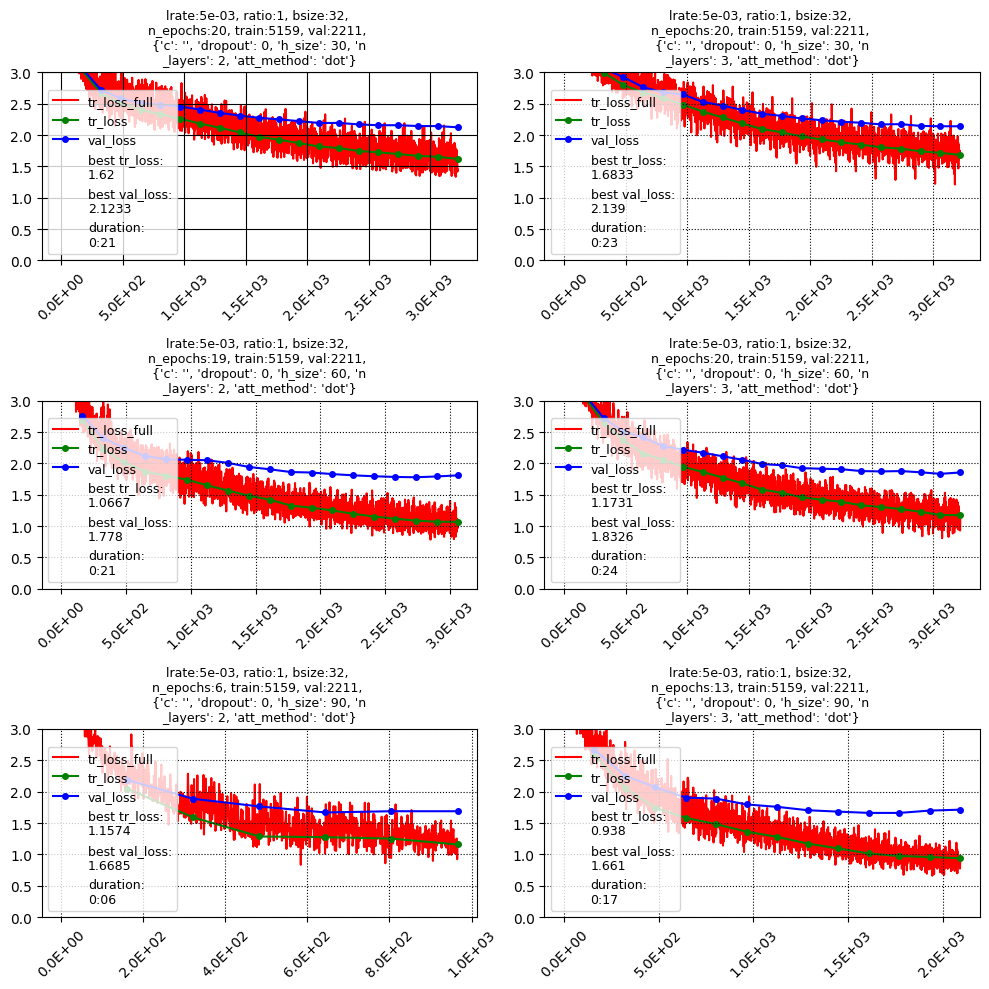

Duration: 1:53:55.798009
END ATLAS CALCULATION
Duration: 1:53:55.798081
21:31:34


In [30]:
# 

params = {     # put the longest before the shortest
    "lrate": [5e-3],   # 
    "dropout": [0],
    "ratio": [1],             
    "acc_steps": [2],          
    "bsize": [16],
    "h_size": [30, 60, 90],
    "n_layers": [2, 3],
    "att_method": ['dot']
}

keys = params.keys()
values = (params[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
start_time  = datetime.datetime.now()  
plt.style.use('default')
count = 1                   
rcParams['figure.figsize'] = 10,10

for i in combinations:        
        #print("Count: "+str(count))
        print("Count: "+str(count), file = terminal_output)

                    #####
        plt.subplot(3, 2, count)                                                                           
        run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device = device, 
                  bsize_eval = 64 , patience = 2, epochs = 20,
                  save = True, path = results_path, atlas = True,
                  vocab = input_lang.n_words, vocab_out = output_lang.n_words, c = "",
                  **i)
        count = count+1
        print("")
        
plt.tight_layout()
plt.show()

print('Duration: {}'.format(datetime.datetime.now() - start_time))    
print("END ATLAS CALCULATION", file=terminal_output)
print('Duration: {}'.format(datetime.datetime.now() - start_time), file=terminal_output)    
print(datetime.datetime.now().strftime("%H:%M:%S"), file=terminal_output)

Count: 1
21:51:55  Starting epoch 0
21:52:45  Calculating figures
21:52:59  Ending epoch 0    train_loss: 2.12   val_loss: 2.24
21:52:59  Starting epoch 1
21:53:51  Calculating figures
21:54:05  Ending epoch 1    train_loss: 1.64   val_loss: 1.85
21:54:05  Starting epoch 2
21:54:57  Calculating figures
21:55:11  Ending epoch 2    train_loss: 1.41   val_loss: 1.78
21:55:11  Starting epoch 3
21:56:04  Calculating figures
21:56:19  Ending epoch 3    train_loss: 1.28   val_loss: 1.67
21:56:19  Starting epoch 4
21:57:14  Calculating figures
21:57:29  Ending epoch 4    train_loss: 1.16   val_loss: 1.67
21:57:29  Starting epoch 5
21:58:24  Calculating figures
21:58:40  Ending epoch 5    train_loss: 1.17   val_loss: 1.69
21:58:40  Starting epoch 6
21:59:36  Calculating figures
21:59:52  Ending epoch 6    train_loss: 1.08   val_loss: 1.65
21:59:52  Starting epoch 7
22:00:50  Calculating figures
22:01:07  Ending epoch 7    train_loss: 1.04   val_loss: 1.66
22:01:07  Starting epoch 8
22:02:04  Ca

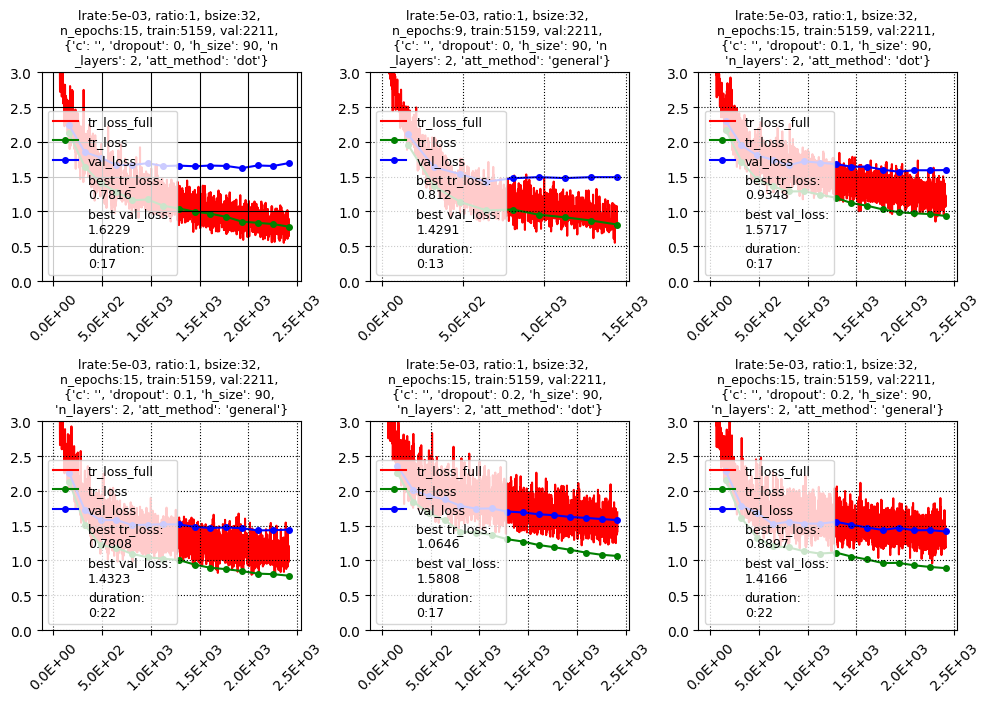

Duration: 1:50:22.670856
END ATLAS CALCULATION
Duration: 1:50:22.670910
23:42:18


In [32]:
# Better manually rename the picture saved in the folder.
# Otherwise there's a slight risk of it being over

params = {     # put the longest before the shortest
    "lrate": [5e-3],  
    "dropout": [0, 0.1, 0.2],
    "ratio": [1],             
    "acc_steps": [2],          
    "bsize": [16],
    "h_size": [90],
    "n_layers": [2],
    "att_method": ['dot', 'general']
}

keys = params.keys()
values = (params[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
start_time  = datetime.datetime.now()  
plt.style.use('default')
count = 1                   
rcParams['figure.figsize'] = 10,10

for i in combinations:        
        #print("Count: "+str(count))
        print("Count: "+str(count), file = terminal_output)

                    #####
        plt.subplot(3, 3, count)                                                                           
        run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device = device, 
                  bsize_eval = 64 , patience = 5, epochs = 15,
                  save = True, path = results_path, atlas = True,
                  vocab = input_lang.n_words, vocab_out = output_lang.n_words, c = "",
                  **i)
        count = count+1
        print("")
        
plt.tight_layout()
plt.show()

print('Duration: {}'.format(datetime.datetime.now() - start_time))    
print("END ATLAS CALCULATION", file=terminal_output)
print('Duration: {}'.format(datetime.datetime.now() - start_time), file=terminal_output)    
print(datetime.datetime.now().strftime("%H:%M:%S"), file=terminal_output)

Count: 1
20:16:16  Starting epoch 0
20:17:25  Calculating figures
20:17:44  Ending epoch 0    train_loss: 2.14   val_loss: 2.26
20:17:44  Starting epoch 1
20:18:49  Calculating figures
20:19:07  Ending epoch 1    train_loss: 1.65   val_loss: 1.82
20:19:07  Starting epoch 2
20:20:13  Calculating figures
20:20:31  Ending epoch 2    train_loss: 1.35   val_loss: 1.66
20:20:31  Starting epoch 3
20:21:38  Calculating figures
20:21:57  Ending epoch 3    train_loss: 1.3   val_loss: 1.55
20:21:57  Starting epoch 4
20:23:06  Calculating figures
20:23:25  Ending epoch 4    train_loss: 1.28   val_loss: 1.58
20:23:25  Starting epoch 5
20:24:36  Calculating figures
20:24:55  Ending epoch 5    train_loss: 1.19   val_loss: 1.57
20:24:55  Starting epoch 6
20:26:04  Calculating figures
20:26:23  Ending epoch 6    train_loss: 1.14   val_loss: 1.55
20:26:23  Starting epoch 7
20:27:33  Calculating figures
20:27:52  Ending epoch 7    train_loss: 1.13   val_loss: 1.54
20:27:52  Starting epoch 8
20:29:04  Cal

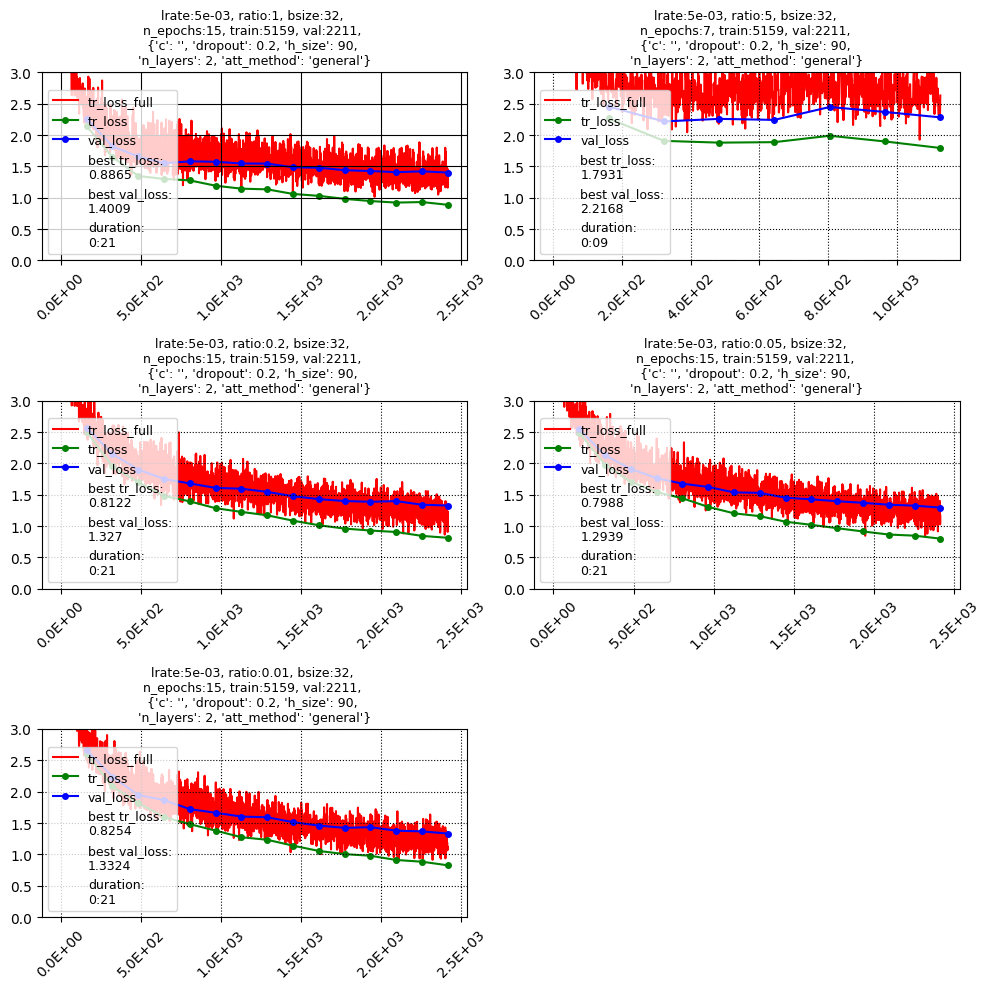

Duration: 1:36:32.520405
END ATLAS CALCULATION
Duration: 1:36:32.520457
21:52:48


In [27]:
# 

params = {     # put the longest before the shortest
    "lrate": [5e-3],  
    "dropout": [0.2],
    "ratio": [1, 5, 0.2, 0.05, 0.01],             
    "acc_steps": [2],          
    "bsize": [16],
    "h_size": [90],
    "n_layers": [2],
    "att_method": ['general']
}

keys = params.keys()
values = (params[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
start_time  = datetime.datetime.now()  
plt.style.use('default')
count = 1                   
                    ###### widath, depth of the plotting canvas
rcParams['figure.figsize'] = 10, 10

for i in combinations:        
        #print("Count: "+str(count))
        print("Count: "+str(count), file = terminal_output)

                    #rows, columns####
        plt.subplot(3, 2, count)                                                                           
        run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device = device, 
                  bsize_eval = 64 , patience = 5, epochs = 15,
                  save = True, path = results_path, atlas = True,
                  vocab = input_lang.n_words, vocab_out = output_lang.n_words, c = "",
                  **i)
        count = count+1
        print("")
        
plt.tight_layout()
plt.show()

print('Duration: {}'.format(datetime.datetime.now() - start_time))    
print("END ATLAS CALCULATION", file=terminal_output)
print('Duration: {}'.format(datetime.datetime.now() - start_time), file=terminal_output)    
print(datetime.datetime.now().strftime("%H:%M:%S"), file=terminal_output)

21:52:48  Starting epoch 0
21:53:53  Calculating figures
21:54:10  Ending epoch 0    train_loss: 2.48   val_loss: 2.55
21:54:10  Starting epoch 1
21:55:16  Calculating figures
21:55:33  Ending epoch 1    train_loss: 2.0   val_loss: 2.14
21:55:33  Starting epoch 2
21:56:38  Calculating figures
21:56:56  Ending epoch 2    train_loss: 1.78   val_loss: 1.92
21:56:56  Starting epoch 3
21:58:02  Calculating figures
21:58:20  Ending epoch 3    train_loss: 1.59   val_loss: 1.81
21:58:20  Starting epoch 4
21:59:26  Calculating figures
21:59:44  Ending epoch 4    train_loss: 1.48   val_loss: 1.73
21:59:44  Starting epoch 5
22:00:53  Calculating figures
22:01:12  Ending epoch 5    train_loss: 1.37   val_loss: 1.68
22:01:12  Starting epoch 6
22:02:20  Calculating figures
22:02:39  Ending epoch 6    train_loss: 1.31   val_loss: 1.64
22:02:39  Starting epoch 7
22:03:47  Calculating figures
22:04:06  Ending epoch 7    train_loss: 1.24   val_loss: 1.61
22:04:06  Starting epoch 8
22:05:17  Calculating 

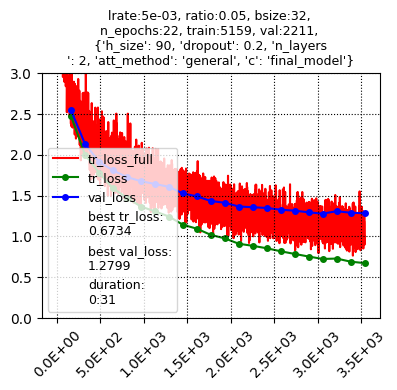

In [28]:
# 
outputs = run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device= device, 
              lrate = 5e-3, ratio = 0.05, bsize = 16, acc_steps = 2, 
                                                    bsize_eval = 64, epochs = 25, patience = 3,
                    save = True, path = results_path, 
                  # the below are passed to the model class
                vocab = input_lang.n_words, h_size = 90, dropout = 0.2, n_layers = 2, 
                    att_method = 'general', vocab_out = output_lang.n_words,
                    c = "final_model"  
              )

In [27]:
1

1